# Medical Image Classification

## 1. 데이터 준비: MedNIST dataset

In [3]:
# 데이터 다운로드
!wget https://raw.githubusercontent.com/mi2rl/datasets/master/mednist.tar.gz

--2021-05-27 08:25:35--  https://raw.githubusercontent.com/mi2rl/datasets/master/mednist.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62087736 (59M) [application/octet-stream]
Saving to: ‘mednist.tar.gz’

mednist.tar.gz      100%[===================>]  59.21M  41.8MB/s    in 1.4s    

2021-05-27 08:25:40 (41.8 MB/s) - ‘mednist.tar.gz’ saved [62087736/62087736]



In [5]:
# 압축 풀기
!tar xzf mednist.tar.gz

In [6]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
dataDir = 'resized' # 데이터 위치
classNames = sorted(os.listdir(dataDir))                    # 각 클래스의 이름들
print(os.listdir(dataDir))
numClass = len(classNames)                                  # Number of classes = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) 
              for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # 각 클래스 별 파일 이름들
numEach = [len(imageFiles[i]) for i in range(numClass)]     # 각 클래스 별 파일 갯수
imageFilesList = []                                         # 모든 파일이름
imageClass = []                                             # 각각의 파일들에 대한 클래스 

for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
    
numTotal = len(imageClass)                                            # 전체 파일 갯수
imageWidth, imageHeight = Image.open(imageFilesList[0]).size          # 각 영상의 사이즈(width, height)

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

['Hand', 'HeadCT', 'ChestCT', 'AbdomenCT', 'BreastMRI', 'CXR']
There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


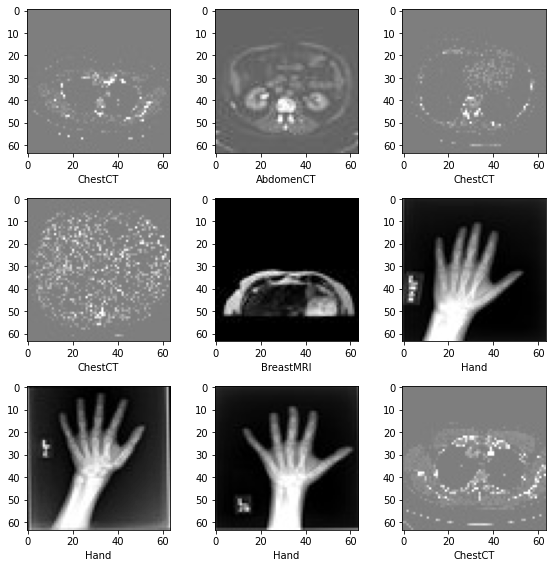

In [9]:
# 전체 이미지 중 9개를 랜덤으로 골라 3x3으로 레이블과 함께 그리기
# -- 여러번 실행하며 이미지들을 살펴보세요 --

plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)): 
    im = Image.open(imageFilesList[k])                      
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    plt.xlabel(classNames[imageClass[k]])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()

In [10]:
# 이미지 리스트 살펴보기
imageFilesList[0:10]

['resized/AbdomenCT/008129.jpeg',
 'resized/AbdomenCT/002641.jpeg',
 'resized/AbdomenCT/003076.jpeg',
 'resized/AbdomenCT/004460.jpeg',
 'resized/AbdomenCT/008498.jpeg',
 'resized/AbdomenCT/005695.jpeg',
 'resized/AbdomenCT/005245.jpeg',
 'resized/AbdomenCT/001787.jpeg',
 'resized/AbdomenCT/005181.jpeg',
 'resized/AbdomenCT/005120.jpeg']

## 2. VGG16을 이용한 분류 실습 (w/ ImageNet pre-trained weight)
![대체 텍스트](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

### ### 2.1. [Quiz] 순서가 섞인 layer들을 VGG16 구성에 맞게 배치해보세요.

In [ ]:
inputs = Input(shape=(224, 224, 3,), name="VGGInput")

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=4096, kernel_size=(7,7), padding='valid', activation='relu')(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
pred = Dense(1000, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)

model.summary()

### 2.2. VGG16 모델 불러오기

In [11]:
from tensorflow.keras.applications import vgg16

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [ ]:
# Model 구성도 plot
import tensorflow as tf
from IPython.display import Image

tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True, show_layer_names=True)
Image(filename='vgg16.png')

In [ ]:
# VGG16 모델을 이용해 prediction 하는 함수
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display # 이미지 출력 함수

def predict_vgg16(model, filename) :
    # 이미지 파일을 읽고 화면에 표시
    image = load_img(filename)
    display(image)

    # 모델 사이즈로 이미지 파일을 읽기
    image = load_img(filename, target_size=(224, 224))

    # 이미지 데이터를 numpy로 변환
    image = img_to_array(image)

    # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
    # 보통 모델을 여러 이미지를 한번에 호출. 
    # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
    # 두번째 224 : 가로
    # 세번째 224 : 세로
    # 네번째 3 : R, G, B 3개
    image = image.reshape((1, 224, 224, 3))

    # VGG16 모델 호출을 위해 데이터 전처리.
    # -255 ~ 255 사이 값으로 정규화한다.
    # 그리고 RGB를 BGR순으로 바꾼다.
    image = vgg16.preprocess_input(image)


    # 이미지를 모델에 적용
    yhat = model.predict(image)

    # 모델 적용된 결과를 파싱
    label = vgg16.decode_predictions(yhat)

    # 가장 확률이 높은 결과를 획득
    label = label[0][0]

    # 라벨과 라벨을 예측한 확률을 출력
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
files = imageFilesList[0:10]

In [ ]:
for file in files:
    predict_vgg16(model, file)

### 2.3. Dataset 나누기: Train / Validation / Test

In [ ]:
validFrac = 0.2   # Define the fraction of images to move to validation dataset
testFrac = 0.2    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"\nValidation =",nValid,"\nTesting =",nTest)

In [ ]:
!mkdir ./train
!mkdir ./valid
!mkdir ./test

In [ ]:
im = Image.open(imageFilesList[0])
# im.show()

# ori -> dataDir = 'resized'  
# local -> dataDir = 'ref/mednist/resized' # 데이터 위치



root, clas, src = imageFilesList[trainList[0]].split('\\')
print(imageFilesList[0])
print(root)
print(clas)
print(src)


dest = os.path.join('ref/mednist/train/', src)
print(dest)

In [ ]:
import shutil
from tqdm import tqdm

for i in tqdm(range(len(trainList))):
    root, clas, src = imageFilesList[trainList[i]].split('/')
    dest = os.path.join('ref/mednist/train/', src)
    shutil.copy(imageFilesList[trainList[i]], dest)

In [ ]:
iimport shutil
from tqdm import tqdm

for i in tqdm(range(len(trainList))):
  root, clas, src = imageFilesList[trainList[i]].split('/')
  dest = os.path.join('ref/mednist/train',clas,src)
  if not os.path.exists(os.path.join('ref/mednist/train',clas)):
    os.mkdir(os.path.join('ref/mednist/train',clas))
  shutil.copy(imageFilesList[trainList[i]], dest)
  
for i in tqdm(range(len(validList))):
  root, clas, src = imageFilesList[validList[i]].split('/')
  dest = os.path.join('./valid',clas,src)
  if not os.path.exists(os.path.join('./valid',clas)):
    os.mkdir(os.path.join('./valid',clas))
  shutil.copy(imageFilesList[validList[i]], dest)
  
    
for i in tqdm(range(len(testList))):
  root, clas, src = imageFilesList[testList[i]].split('/')
  dest = os.path.join('./test',clas,src)
  if not os.path.exists(os.path.join('./test',clas)):
    os.mkdir(os.path.join('./test',clas))
  shutil.copy(imageFilesList[testList[i]], dest)

### 2.4. Image Data Generator 정의 (+Data Augmentation)
**Keras API - ImageDataGenerator: 일정한 규칙으로 만들어진 폴더구조에서 데이터셋을 자동으로 불러와 학습에 사용할 수 있게 도와주는 API**
![대체 텍스트](https://miro.medium.com/max/875/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720  
**Data augmentation: 데이터에 다양한 형태의 변화를 임의로 생성하여 데이터의 갯수와 다양성을 증가시키는 방법**
![대체 텍스트](https://miro.medium.com/max/1250/1*rvwzKkvhlDN3Wo_4Oay_4Q.png)
https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dropout

def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


# dataDir = 'ref/mednist/resized' # 데이터 위치

train_dir = 'ref/mednist/train'
validation_dir = 'ref/mednist/valid'
test_dir = 'ref/mednist/test'
batch_size = 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input_vgg,
      rotation_range=20, # 회전 최대 20도
      width_shift_range=0.2, # 좌우 이동
      height_shift_range=0.2, # 상하 이동
      horizontal_flip=True, # 좌우 반전
      vertical_flip=True, # 상하 반전
      )
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 테스트에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)


# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_num=len(train_generator.class_indices)

custom_labels = list(validation_generator.class_indices.keys())

### 2.5. VGG16 as a Feature Extractor

In [ ]:
# 모델 불러오기
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_model.summary()

# Convolution Layer를 학습되지 않도록 고정 
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
# 새로운 모델 생성하기
last = vgg_model.output
 
# VGG16모델에 Fully Connected부분을 재구성해서 추가
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(class_num, activation='softmax')(x)

model = Model(vgg_model.input, pred)

In [ ]:
# 새로운 모델 요약
model.summary()

# 새로운 모델 저장
vgg16_model_path = 'vgg16_finetuning.h5'

model.save(vgg16_model_path)

### 2.6. 새로운 모델 학습

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

# 모델 로딩
model = load_model(vgg16_model_path)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

# 모델 학습
history = model.fit(
      x=train_generator,
      steps_per_epoch=100 ,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# 모델 저장
model.save(vgg16_model_path)

### 2.7. 학습 결과 시각화

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
valacc = history.history['val_acc']
valloss = history.history['val_loss']


epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, valacc, 'b--', label='val_accuracy')
plt.plot(epochs, valloss, 'r--', label='val_loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

### 2.8. 학습된 모델을 이용해 Test 데이터에 대한 Prediction

In [ ]:
# 테스트에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        shuffle=False)

model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)